### Generative Adversarial Networks: A toy example

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Let's start with a simple distribution from which to draw our "real" data from.

$$x \sim \mathcal{N} \left( [1,1],\begin{bmatrix}
    1       & 0.8  \\
    0.8       & 1
\end{bmatrix} \right)$$

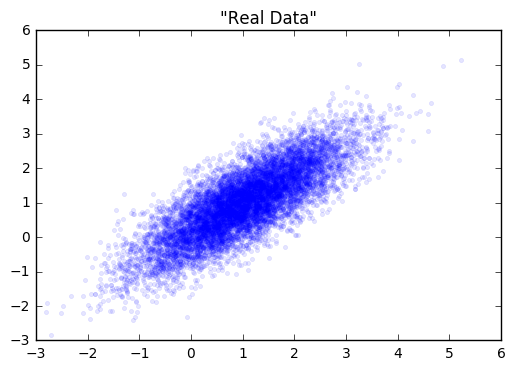

In [2]:
def sim_real_data(n=10000):
    mu = np.array([1,1])
    sigma = np.array([[1,0.8],[0.8,1]])
    return np.random.multivariate_normal(mu,sigma,n)

training_data = sim_real_data()
plt.plot(training_data[:,0],training_data[:,1],'.',alpha=0.1)
plt.title('"Real Data"');

Next, we'll create our generator and discriminator networks using tensorflow. Each will be a three layer, fully connected network with relu's in the hidden layers.

In [42]:
import tensorflow as tf

num_labels = 2
num_relu = 64
graph = tf.Graph()
n_vars = 2

with graph.as_default():

    ##### Training Data #####
    input_dataset = tf.placeholder(tf.float32,
                            shape=(None, n_vars))
    
    ######################
    ##### Generative #####
    ######################
    input_rands = tf.placeholder(tf.float32,
                                    shape=(None, n_vars))
  
    # Generative Variables.
    weights = tf.Variable(
        tf.truncated_normal([n_vars, num_relu]))
    biases = tf.Variable(tf.zeros([num_relu]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_relu, num_relu]))
    biases2 = tf.Variable(tf.zeros([num_relu]))
    weights3 = tf.Variable(
        tf.truncated_normal([num_relu, num_labels]))
    biases3 = tf.Variable(tf.zeros([num_labels]))
    generative_var_list = [weights,
                          biases,
                          weights2,
                          biases2,
                          weights3,
                          biases3]
  
    # Generative computation.
    logits = tf.matmul(input_rands, weights) + biases
    hidden_layer = tf.nn.relu(logits)
    logits2 = tf.matmul(hidden_layer, weights2) + biases2
    hidden_layer2 = tf.nn.relu(logits2)
    
    generated_data = tf.matmul(hidden_layer2, weights3) + biases3
    
    # Stack the generated data with the input data
    discriminator_input = tf.concat(0, [generated_data, input_dataset])
    labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    
    ##########################
    ##### Discriminative #####
    ##########################
    
    # Discriminative Variables.
    weights_d = tf.Variable(
        tf.truncated_normal([n_vars, num_relu]))
    biases_d = tf.Variable(tf.zeros([num_relu]))
    weights2_d = tf.Variable(
        tf.truncated_normal([num_relu, num_relu]))
    biases2_d = tf.Variable(tf.zeros([num_relu]))
    weights3_d = tf.Variable(
        tf.truncated_normal([num_relu, num_labels]))
    biases3_d = tf.Variable(tf.zeros([num_labels]))
    discriminative_var_list = [weights_d,
                          biases_d,
                          weights2_d,
                          biases2_d,
                          weights3_d,
                          biases3_d]
    
    # Discriminative Network computation.
    logits_d = tf.matmul(discriminator_input, weights_d) + biases_d
    hidden_layer_d = tf.nn.relu(logits_d)
    logits2_d = tf.matmul(hidden_layer_d, weights2_d) + biases2_d
    hidden_layer2_d = tf.nn.relu(logits2_d)
    logits3_d = tf.matmul(hidden_layer2_d, weights3_d) + biases3_d
    
    discriminative_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits3_d, labels) +
             0.005 * tf.nn.l2_loss(weights_d) +
             0.005 * tf.nn.l2_loss(weights2_d) +
             0.005 * tf.nn.l2_loss(weights3_d))
  
    # Descriminative Optimizer.
    discriminative_optimizer = tf.train.GradientDescentOptimizer(10e-3).minimize(discriminative_loss,
                                                                                var_list=discriminative_var_list)
  
    # Predictions made by the discriminator.
    prediction = tf.nn.softmax(logits3_d)
    
    # generative_loss 
    generative_loss = - tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits3_d, labels) +
             0.005 * tf.nn.l2_loss(weights) +
             0.005 * tf.nn.l2_loss(weights2) +
             0.005 * tf.nn.l2_loss(weights3))
    
    # Generative Optimizer.
    generative_optimizer = tf.train.GradientDescentOptimizer(10e-3).minimize(generative_loss,
                                                                            var_list=generative_var_list)  

Next, we'll fit each model in turn. Note that we gave each optimizer a list of variables to update via gradient descent. This is because we don't want to update the weights of the discriminator while we're updating the weights of the generator, and _visa versa_.

Initialized
loss at step 0: discriminative: 223.166656, generative: -43.446068


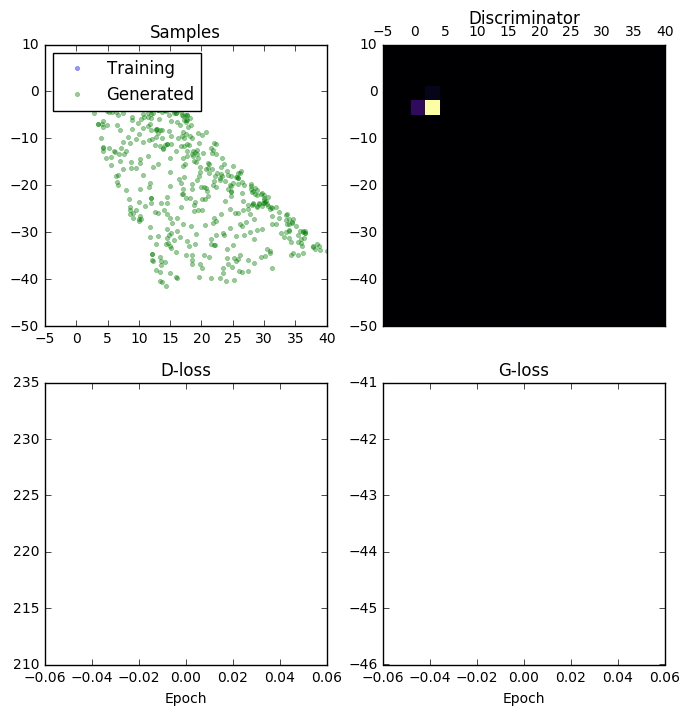

loss at step 500: discriminative: 8.150620, generative: -9.067722


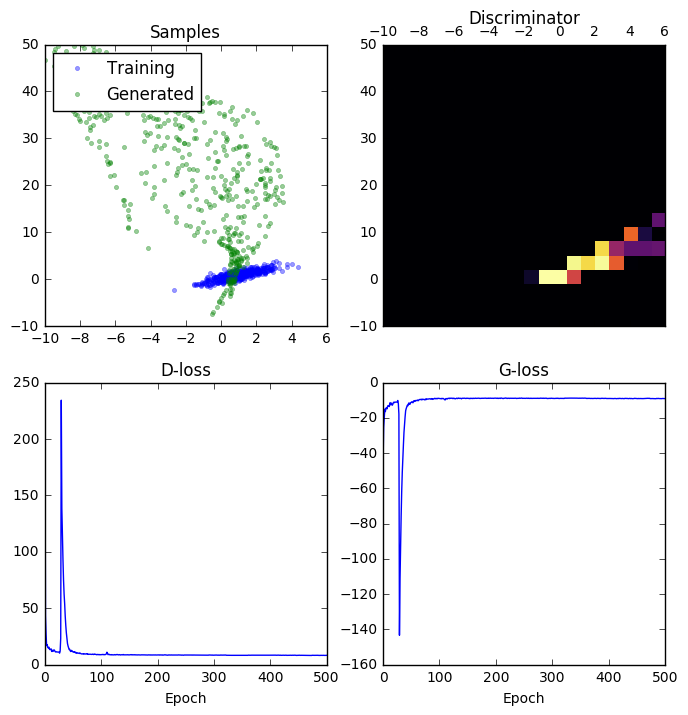

loss at step 1000: discriminative: 7.746095, generative: -9.503428


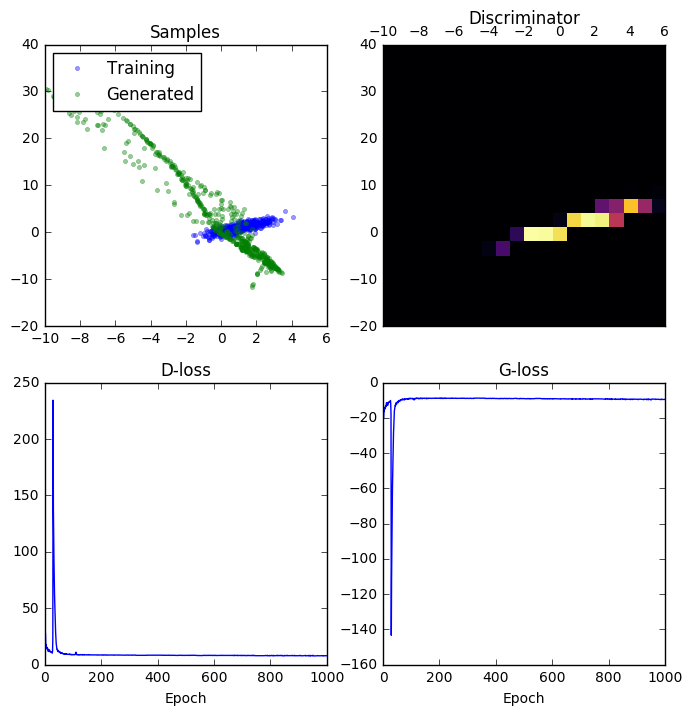

loss at step 1500: discriminative: 7.429594, generative: -10.012774


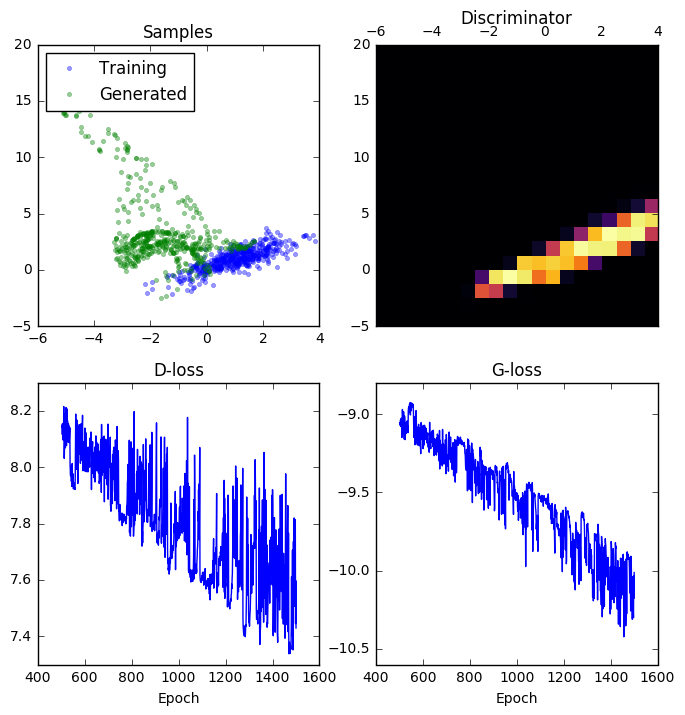

loss at step 2000: discriminative: 7.205247, generative: -10.595505


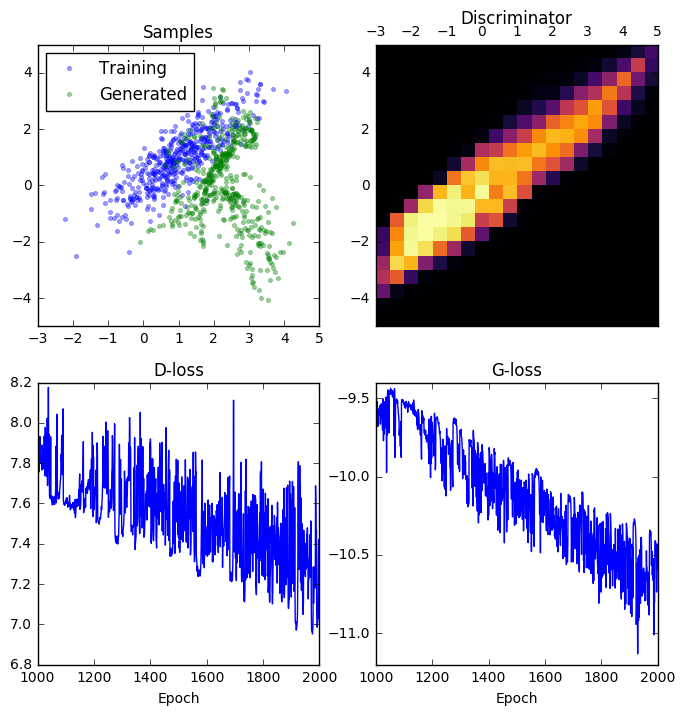

loss at step 2500: discriminative: 7.153162, generative: -11.333523


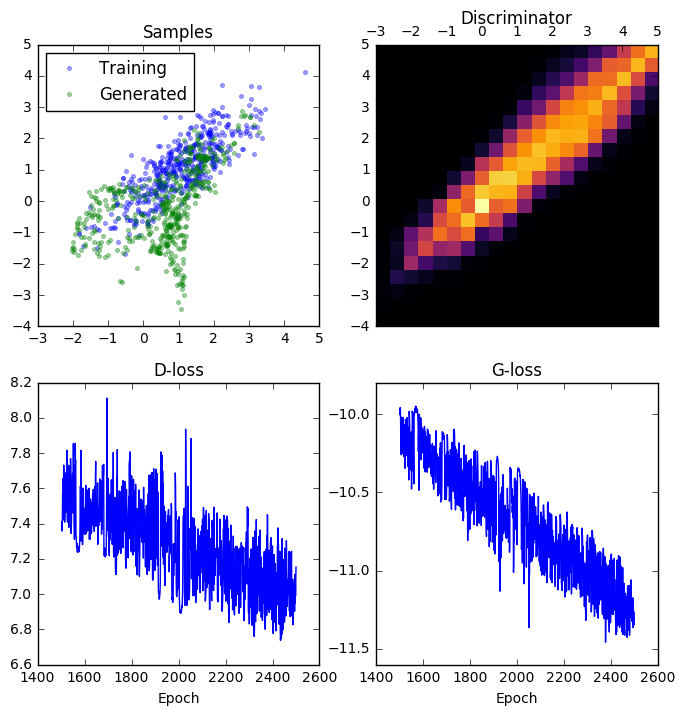

loss at step 3000: discriminative: 6.693544, generative: -11.802803


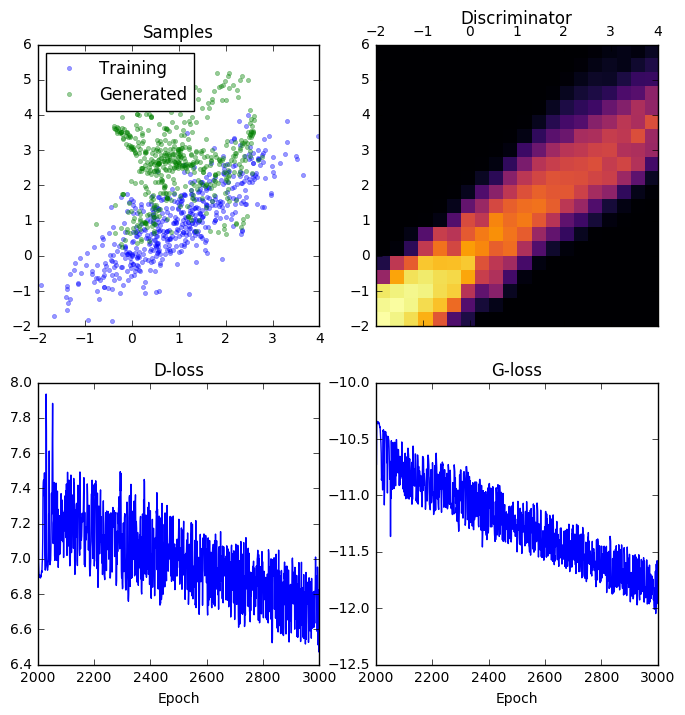

loss at step 3500: discriminative: 6.412287, generative: -12.415071


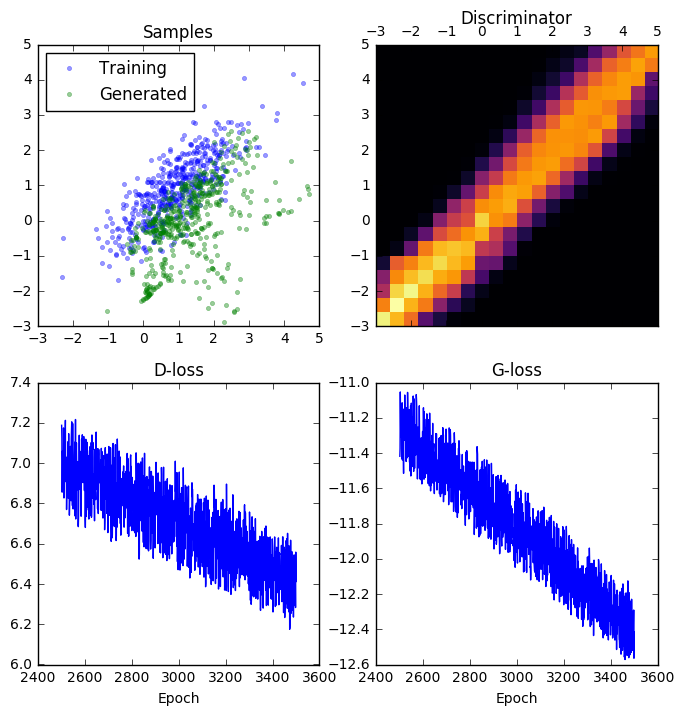

loss at step 4000: discriminative: 6.102245, generative: -12.959238


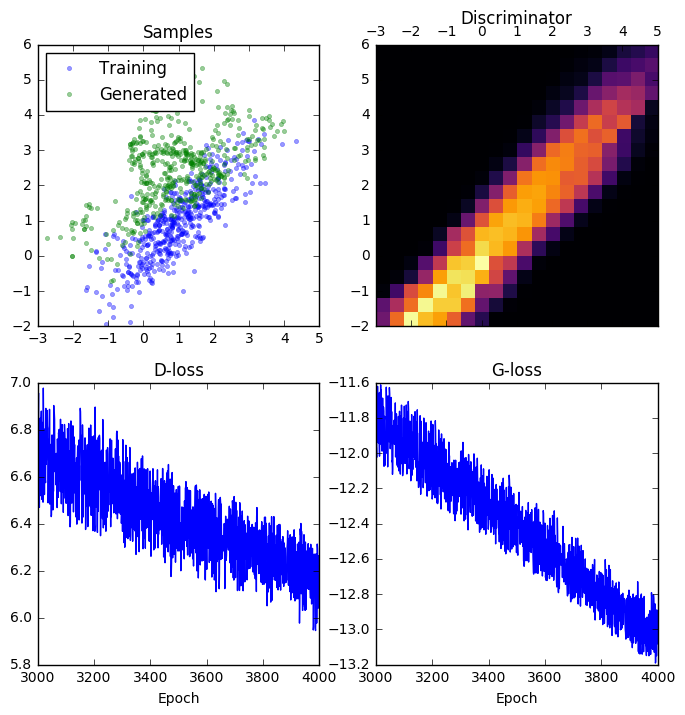

In [51]:
img_path = 'GANtoys'
num_steps = 40001

n = 500
batch_labels = np.zeros((n*2,2))
batch_labels[:n,0] = 1
batch_labels[n:,1] = 1
np.random.seed(1234)

dl_l = []
gl_l = []

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        rands = np.random.rand(n,2)
        #rands = np.random.randn(n,2)
        training_batch = sim_real_data(n)
        
        feed_dict = {input_dataset : training_batch, labels : batch_labels, input_rands: rands}
        _, dl = session.run(
                [discriminative_optimizer, discriminative_loss], feed_dict=feed_dict)
        
        _, gl, gd, di,pr = session.run(
                [generative_optimizer, generative_loss, generated_data, discriminator_input,prediction], feed_dict=feed_dict)
        
        dl_l.append(dl)
        gl_l.append(gl)
        
        if (step % 5 == 0):
            fig, ax = plt.subplots(2,2,figsize=(8,8))
            ax[0,0].plot(training_batch[:,0],training_batch[:,1],'.',alpha=0.4,label='Training')
            ax[0,0].plot(gd[:,0],gd[:,1],'.',alpha=0.4,label='Generated')
            ax[0,0].legend(loc=2,numpoints=1)
            ax[0,0].set_title('Samples')
            
            ### Map of prediction space of the D-net ###
            resolution = 20
            nx, ny = (resolution, resolution)
            x_min, x_max = ax[0,0].get_xlim()
            y_min, y_max = ax[0,0].get_ylim()
            x = np.linspace(x_min, x_max, nx)
            y = np.linspace(y_min, y_max, ny)
            xv, yv = meshgrid(x, y)
            
            
            xy = np.array([yv.reshape(resolution*resolution),xv.reshape(resolution*resolution)]).T
            feed_dict = {input_dataset : xy, labels : batch_labels, input_rands: rands}
            pr, gd = session.run(
                [prediction, generated_data], feed_dict=feed_dict)

            pr_grid = pr[n:,1].reshape((resolution,resolution))
            ax[0,1].matshow(pr_grid, aspect='auto', cmap='inferno', origin='lower', extent=(x_min, x_max, y_min, y_max)) # origin='lower'
            ax[0,1].set_title('Discriminator')
            #cbar = fig.colorbar(ax[3])
            
            #############################################
            
#             ax[1].hist(pr[:,1],bins=50,alpha=0.1, label='Pred Training')
#             ax[1].hist(pr[:,0],bins=50,alpha=0.1, label='Pred Generated')
            
#             ax[1].legend(loc=0)
            
            loss_window = max(0,len(dl_l)+1-1000)
            ax[1,0].plot(range(loss_window,step+1),dl_l[loss_window:],label='D-loss')
            ax[1,0].set_title('D-loss')
            ax[1,1].plot(range(loss_window,step+1),gl_l[loss_window:],label='- G-loss')
            ax[1,1].set_title('G-loss')
            ax[1,0].set_xlabel('Epoch')
            ax[1,1].set_xlabel('Epoch')
            
            #ax[1,0].legend(loc=0)
            #ax[1,1].legend(loc=0)
            
            plt.savefig(img_path + "/%06d" % step + '.png')
            if (step % 500 == 0):
                print("loss at step %d: discriminative: %f, generative: %f" % (step, dl,gl))
                plt.show()
            plt.close()
            

#### Create a video out of the images

In [32]:
%%bash
cd GANtoys
ffmpeg -framerate 10 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p ToyGAN.mp4
# http://trac.ffmpeg.org/wiki/Create%20a%20video%20slideshow%20from%20images

ffmpeg version 3.1.1 Copyright (c) 2000-2016 the FFmpeg developers
  built with Apple LLVM version 7.0.2 (clang-700.1.81)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/3.1.1 --enable-shared --enable-pthreads --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-opencl --enable-libx264 --enable-libmp3lame --enable-libxvid --disable-lzma --enable-vda
  libavutil      55. 28.100 / 55. 28.100
  libavcodec     57. 48.101 / 57. 48.101
  libavformat    57. 41.100 / 57. 41.100
  libavdevice    57.  0.101 / 57.  0.101
  libavfilter     6. 47.100 /  6. 47.100
  libavresample   3.  0.  0 /  3.  0.  0
  libswscale      4.  1.100 /  4.  1.100
  libswresample   2.  1.100 /  2.  1.100
  libpostproc    54.  0.100 / 54.  0.100
Input #0, image2, from '*.png':
  Duration: 00:00:08.20, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1600x400 [SAR 3937:3937 DAR 4:1], 5 fps, 5 tbr, 5 tbn, 5 tbc
File 'out.mp4'